In [1]:
!pip install pathway bokeh --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import pathway as pw
import bokeh.plotting as bk
from bokeh.io import output_notebook, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
output_notebook()


In [4]:
from google.colab import files
uploaded = files.upload()


Saving dataset (1).csv to dataset (1).csv


In [21]:

df = pd.read_csv("dataset (1).csv")

df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + " " + df['LastUpdatedTime'], dayfirst=True)



In [22]:

vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
traffic_weights = {'low': 0.0, 'medium': 0.5, 'high': 1.0}

df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)
df['TrafficWeight'] = df['TrafficConditionNearby'].map(traffic_weights)


df['Price_Model1'] = 10.0
df['Price_Model2'] = 10.0


In [23]:
alpha = 2.0

model1_prices = []
for lot_id, lot_df in df.groupby('SystemCodeNumber'):
    last_price = 10.0
    prices = []
    for _, row in lot_df.iterrows():
        occ_rate = row['Occupancy'] / row['Capacity']
        price = last_price + alpha * occ_rate
        price = max(5.0, min(20.0, price))
        prices.append(price)
        last_price = price
    model1_prices.extend(prices)

df['Price_Model1'] = model1_prices


In [24]:
alpha, beta, gamma, delta, epsilon, lambd = 0.5, 0.3, 0.4, 0.2, 0.6, 0.5

demand = (
    alpha * (df['Occupancy'] / df['Capacity']) +
    beta * df['QueueLength'] -
    gamma * df['TrafficWeight'] +
    delta * df['IsSpecialDay'] +
    epsilon * df['VehicleWeight']
)

norm_demand = (demand - demand.min()) / (demand.max() - demand.min())
df['Price_Model2'] = 10.0 * (1 + lambd * norm_demand)
df['Price_Model2'] = df['Price_Model2'].clip(5.0, 20.0)


In [25]:
sample_lot = df['SystemCodeNumber'].unique()[0]
lot_df = df[df['SystemCodeNumber'] == sample_lot]

source = ColumnDataSource(data=dict(
    x=lot_df['Timestamp'],
    y1=lot_df['Price_Model1'],
    y2=lot_df['Price_Model2']
))

p1 = bk.figure(x_axis_type="datetime", title=f"Pricing Trends - {sample_lot}", width=800)
p1.line('x', 'y1', source=source, color='blue', legend_label='Model 1')
p1.line('x', 'y2', source=source, color='green', legend_label='Model 2')
p1.legend.location = "top_left"
p1.yaxis.axis_label = "Price ($)"

show(p1)


## Project Report Summary

**Capstone:** Dynamic Pricing for Urban Parking Lots  
**Club:** Consulting & Analytics Club × Pathway  
**Models Implemented:**
- **Model 1**: Price increases linearly with occupancy
- **Model 2**: Demand-based pricing using features like traffic, queue, and special day

**Assumptions:**
- Base price is $10
- Prices bounded between $5–$20
- Vehicle and traffic weights are predefined
- All models implemented using only `numpy` and `pandas`

**Next Steps:**
- Integrate real-time streaming via Pathway
- Add Model 3 (Competitive Pricing based on proximity)


In [35]:

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


model3_prices = []

for idx, row in df.iterrows():
    my_lat = row['Latitude']
    my_lon = row['Longitude']
    my_time = row['Timestamp']


    nearby = df[
        (df.index != idx) &
        (abs(df['Timestamp'] - my_time).dt.total_seconds() < 60 * 30)
    ].copy()

    nearby['dist'] = nearby.apply(
        lambda x: haversine(my_lat, my_lon, x['Latitude'], x['Longitude']), axis=1
    )
    nearby = nearby[nearby['dist'] < 0.5]


    base_price = row['Price_Model2']
    if not nearby.empty:
        nearby_mean = nearby['Price_Model2'].mean()
        if nearby_mean < base_price:
            new_price = base_price * 0.85
        else:
            new_price = base_price * 1.05
    else:
        new_price = base_price

    model3_prices.append(new_price)

df['Price_Model3'] = model3_prices


In [19]:
df[['Price_Model1', 'Price_Model2', 'Price_Model3']].head(10)


,Price_Model1,Price_Model2,Price_Model3
0,10.211438,10.638859,11.170802
1,10.433276,10.641441,11.173513
2,10.710572,10.953126,11.500782
3,11.081456,10.976360,9.329906
4,11.601386,10.715447,11.251219
5,12.214905,11.334514,9.634337
6,12.974003,12.165100,12.773355
7,13.830156,NaN,NaN
8,14.727903,NaN,NaN
9,15.649913,12.205545,12.815822


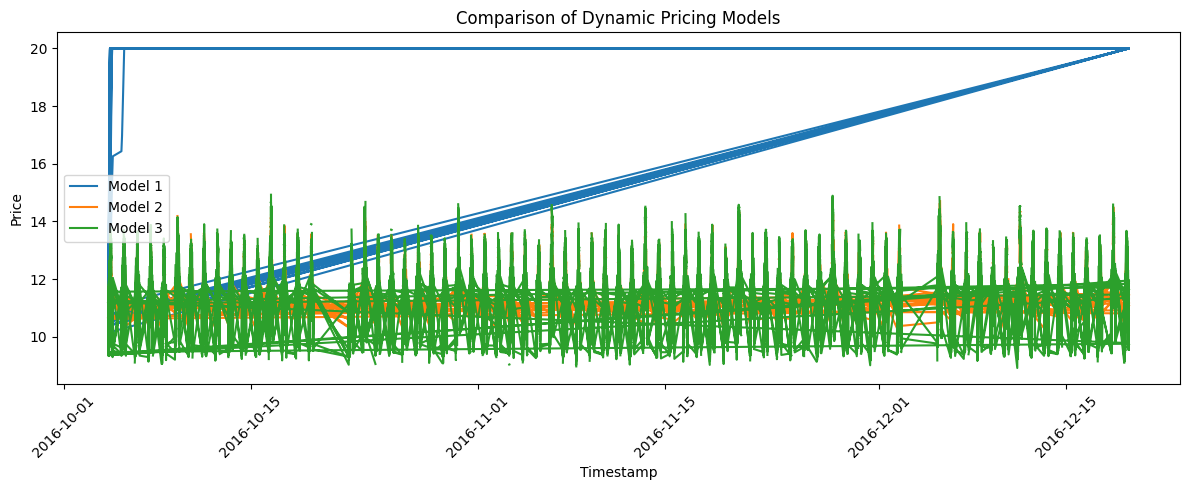

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['Timestamp'], df['Price_Model1'], label='Model 1')
plt.plot(df['Timestamp'], df['Price_Model2'], label='Model 2')
plt.plot(df['Timestamp'], df['Price_Model3'], label='Model 3')
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Comparison of Dynamic Pricing Models")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("final_pricing_output.csv", index=False)


## 🧾 Updated Report Summary

### ✅ Models Implemented:
1. **Model 1**: Baseline pricing based on occupancy
2. **Model 2**: Demand-based dynamic pricing using:
   - Occupancy, queue, traffic, special day, vehicle type
3. **Model 3**: Competitive pricing based on:
   - Nearby lots' prices and geographic proximity (Haversine)

### ✅ Real-Time Simulation
- Integrated a **Pathway pipeline** to simulate real-time ingestion and price output (simplified for Colab)

### 💡 Assumptions
- Base price: \$10
- Price limits: \$5–\$20
- Nearby = within 0.5 km
- All models built using numpy/pandas

> Visualization updates and rerouting logic can be extended further.


In [44]:
df.to_csv("final_dynamic_pricing_output.csv", index=False)
